### 📌 Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import re
import emoji
import plotly.express as px
import plotly.graph_objects as go

In [2]:
with open('WhatsApp_Chat.txt', mode = 'rt', encoding='UTF-8') as df:
    data = df.read()

In [3]:
pattern = r"\d{1,2}/\d{1,2}/\d{1,2},\s\d{1,2}:\d{1,2}\s\w{1,2}\s-\s"
message_text = re.split(pattern, data)[1:]
message_date = re.findall(pattern, data)
# [1:] because the 0th index string is always empty " "

# Resolved error  - The warning you’re encountering is due to the use of backslashes (\) in string literals in Python, which can be interpreted as escape sequences. To resolve this, you can either use raw strings by prefixing the string with r, or you can double the backslashes.

In [4]:
# Splitting whatsapp message and people messages
whatsapp_msg, people_msg = [], []
whatsapp_msg_date, people_msg_date = [], []

for i in range(len(message_text)):
    if message_text[i].find(":") == -1:
        whatsapp_msg.append(message_text[i])
        whatsapp_msg_date.append(message_date[i])
    else:
        people_msg.append(message_text[i])
        people_msg_date.append(message_date[i])

In [5]:
# Splitting name and chat
pattern = r"()"
member_name, member_chat = [], []
for i in range(len(people_msg)):
    data = people_msg[i].split(": ")
    member_name.append(data[0])
    member_chat.append(data[1][:-1])

In [6]:
# Splitting date time and am pm
pattern = r"(\d{2}/\d{2}/\d{2}),\s(\d{1,2}:\d{2})\s(\w{2})"
date_, month, year = [], [], []
hour, minute = [], []

for i in range(len(people_msg_date)):
        fetch_all = re.search(pattern, people_msg_date[i])

        # group 1 - date, month and year
        date_pattern = r"(\d{2})/(\d{2})/(\d{2})"
        full_date = re.search(date_pattern, fetch_all.group(1))
        date_.append(full_date.group(1))
        month.append(full_date.group(2))
        year.append(full_date.group(3))

        # group 3 - format
        format_ = fetch_all.group(3)

        # group 2 - hour, minutes
        full_time = fetch_all.group(2).split(":")
        if format_ == 'pm':
                hour.append(int(full_time[0]) + 12)
                minute.append(int(full_time[1]))
        else:
                hour.append(int(full_time[0]))
                minute.append(int(full_time[1]))


In [7]:
chat = pd.DataFrame(
    {
        'Name': member_name,
        'Message': member_chat,
        'Date': date_,
        'Month': month,
        'Year': year,
        'Hour': hour,
        "Minute": minute
    }
)

In [8]:
dtype_mapping = {
    'Name': np.str_,
    'Message': np.str_,
    'Date': np.int32,
    'Month': np.int32,
    'Year': np.int32,
    'Hour': np.int32,
    'Minute': np.int32
}

# Optimize type conversion
chat = chat.astype(dtype_mapping)

In [9]:
chat["Day"] = (chat['Date'].astype(np.str_) + r'/' + chat['Month'].astype(np.str_) + r'/' + chat['Year'].astype(np.str_)).apply(lambda x: pd.to_datetime(x).day_name())

In [10]:
months_dict = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}
chat['Month_name'] = chat['Month'].map(months_dict)

📌 `Note` - This is just for securing the names of my chat

In [11]:
names = ["Chad", "Sam", "Dante", "Tony", "Dominic", "Brian", "Letty", "Mia", "Roman", "Tej", "Luke", "Deckard", "Giselle" ,"Han", "Sean", "Cipher", "Jakob", "Elena", "Ramsey", "Nobody", "Angela", "Jessie", "Johnny", "Leon", "Vince", "Lynda", "Rita", "Tego"]

actual = chat['Name'].unique()

mapped = {
    actual[i] : names[i] for i in range(actual.shape[0])
}
chat['Name'] = chat['Name'].map(mapped)

In [12]:
chat.head(10)

,Name,Message,Date,Month,Year,Hour,Minute,Day,Month_name
0,Chad,<Media omitted>,22,3,23,9,10,Wednesday,March
1,Sam,<Media omitted>,22,3,23,10,5,Wednesday,March
2,Dante,<Media omitted>,22,3,23,11,3,Wednesday,March
3,Tony,<Media omitted>,22,3,23,24,25,Wednesday,March
4,Sam,<Media omitted>,23,3,23,21,24,Thursday,March
5,Dominic,🤪🤪,23,3,23,22,6,Thursday,March
6,Dominic,<Media omitted>,24,3,23,22,51,Friday,March
7,Sam,🤣🤣🤣,24,3,23,22,56,Friday,March
8,Brian,😁😁😁😀😀,25,3,23,8,17,Saturday,March
9,Letty,<Media omitted>,25,3,23,9,52,Saturday,March


---

### 📌 Task 1 - Top Statictics
- Total Messages
- Total Words
- Total Shared
- Total Link Shared
- Total Emojis

In [14]:
# Total Messages
total_messages = chat.shape[0]

# Total Media Shared
total_media = chat[chat['Message'] == "<Media omitted>"].shape[0]

# Total chats
total_chats = total_messages - total_media

# Total Emojis
def count_emojis(text):
    count = 0
    for char_ in text:
        if emoji.is_emoji(char_):
            count += 1
    return count

total_emojis = chat['Message'].apply(count_emojis).sum()

# Total Words and Links
def count_words_and_links(text: str) -> int:
    link_count, word_count = 0, 0
    words = text.split()

    for word in words:
        if word.startswith("https://"):
            link_count += 1
        else:
            word_count += 1

    return word_count, link_count

words_only_chat = chat[chat['Message'] != "<Media omitted>"]

words_and_links_tp = words_only_chat['Message'].apply(count_words_and_links)

total_words, total_links = 0, 0
for count in words_and_links_tp:
    total_words += count[0]
    total_links += count[1]

total_words = np.abs(total_words - total_emojis)

In [15]:
print(total_messages, total_words, total_media, total_links, total_emojis)

2966 4105 775 24 8735


In [22]:
colors = [
    "White", "orange", "lightblue", "orange", "lightgreen", "violet",
    "orange", "lightpink", "lightyellow", "lightgray"
]
fig = go.Figure(go.Sunburst(
    labels=["Total Messages", 'Total Chats', 'Total Media', 'Total Links', 'Total Words', 'Total Emojis'],
    parents=[""] + ['Total Messages'] * 3 + ['Total Chats'] * 2,
    values=[total_messages, total_chats, total_media, total_links, total_words, total_emojis],
    marker=dict(colors=colors)
))

# Update layout for tight margins
fig.update_layout(
    margin=dict(t=50, l=10, r=10, b=10),
    title="📊 Top Statics",
    title_x = 0.5
)

---

### 📌 Task 2 - Monthly Timeline

In [23]:
month_and_year_group = chat.groupby(['Month', 'Year'])
month_and_year_name = month_and_year_group.count()[['Name']].sort_index(level = ['Year', 'Month']).reset_index()
month_and_year_name['Month'] = month_and_year_name['Month'].map(months_dict)
month_and_year_name['Month_and_Year'] = month_and_year_name['Month'] + ' 20' + month_and_year_name['Year'].astype(np.str_)
month_and_year_name

,Month,Year,Name,Month_and_Year
0,March,23,49,March 2023
1,April,23,140,April 2023
2,May,23,222,May 2023
3,June,23,169,June 2023
4,July,23,158,July 2023
5,August,23,108,August 2023
6,September,23,227,September 2023
7,October,23,106,October 2023
8,November,23,91,November 2023
9,December,23,266,December 2023


In [25]:
fig = go.Figure(data = go.Scatter
    (
      x = month_and_year_name['Month_and_Year'],
      y = month_and_year_name['Name'],
      name = "Monthly Chat Insights",
      mode = 'lines+markers',
      marker = dict(size=9, color = 'black'),
      line=dict(width=0.7),
      hovertemplate="%{y}: %{x}"
    )
)
fig.update_layout(
  height=500, 
  width=900,
  xaxis_title = "Monthly Timeline ➡️",
  yaxis_title = "Message Count ➡️",
  title="Monthly Chat Insights 📅",
  title_x=0.5,
  template="plotly_white",
  margin = dict(l=40, r=40)
)
fig.show()

---

### 📌 Task 3 - Weekly Timeline

In [26]:
unique_days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
weekly_chat_count = []

i = 0
while i < chat.shape[0]:
    current_day = chat.loc[i, 'Day']
    message_count = 0

    while current_day == 'Sunday': # Handling case if starting day is sunday
        message_count += 1
        i += 1
        if i >= chat.shape[0]:
            weekly_chat_count.append(message_count)
            break
        current_day = chat.loc[i, 'Day']

    while current_day != 'Sunday': # Handling case if starting day is not a sunday
        message_count += 1
        i += 1
        if i >= chat.shape[0]:
            weekly_chat_count.append(message_count)
            break
        current_day = chat.loc[i, 'Day']
    if i >= chat.shape[0]:
        break
    weekly_chat_count.append(message_count)

In [28]:
fig = go.Figure(data = go.Scatter
    (
        x = np.arange(1, len(weekly_chat_count) + 1),
        y = weekly_chat_count,
        name = "Weekly Chat Insights",
        mode='lines+markers',
        marker=dict(size=7, color='black'),
        line=dict(width=0.75),
        hovertemplate="%{y} chats: week %{x}"
    )
)

fig.update_layout(
  height=500, 
  width=900,
  xaxis_title="Weekly Timeline ➡️",
  yaxis_title="Message Count ➡️",
  title="Weekly Chat Insights 📅",
  title_x=0.5,
  template="plotly_white",
  margin = dict(l=10, r=10)
)
fig.show()

---

### 📌 Task 4 - Monthly and Daily Engagement Analysis

In [29]:
day_chat_analysis = chat.groupby('Day')['Name'].count()
month_chat_analysis = chat.groupby('Month_name')['Name'].count()

In [31]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Bar
    (
        x = day_chat_analysis.index,
        y = day_chat_analysis,
        name = "Days",
        showlegend=False
    ), row = 1, col = 1
)
fig.update_xaxes(title_text='Days ➡️', row=1, col=1)
fig.update_yaxes(title_text='Message Count ➡️', row=1, col=1)


fig.add_trace(go.Bar
    (
        x = month_chat_analysis.index,
        y = month_chat_analysis,
        name = "Months",
        showlegend=False
    ), row = 1, col = 2
)
fig.update_xaxes(title_text='Months ➡️', row=1, col=2)
fig.update_yaxes(title_text='Message Count ➡️', row=1, col=2)


fig.update_layout(
  height=500, 
  width=900,
  title="Monthly and Daily Engagement Analysis 📊",
  title_x=0.5,
  template="plotly_white",
  margin = dict(l=10, r=10),
)
fig.show()

---

### 📌 Weekly Activity Map

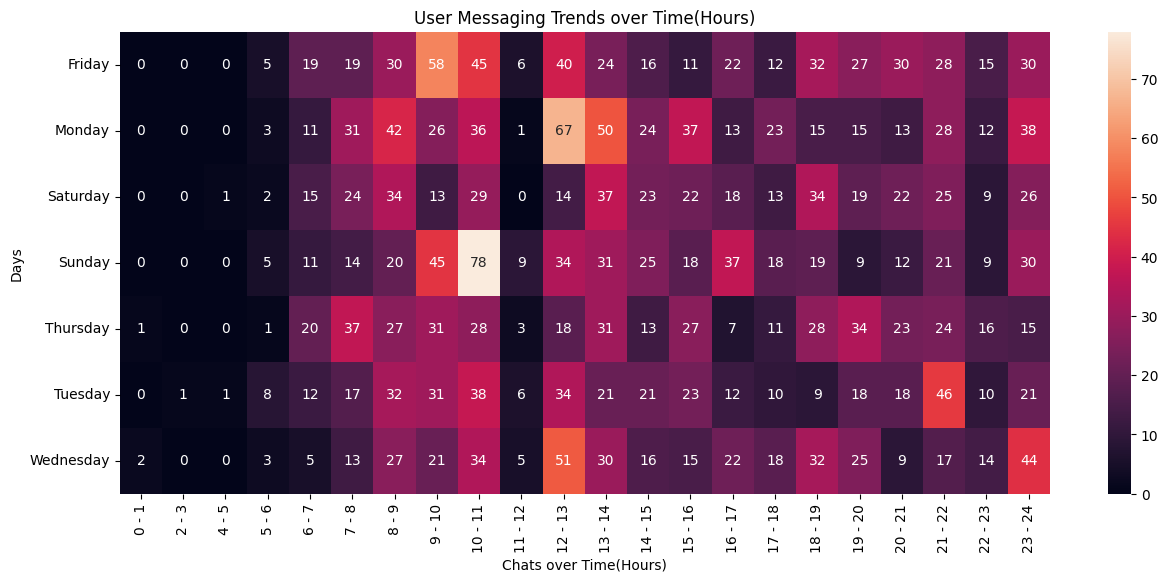

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

pvt = chat.pivot_table(
        index = 'Day',
        columns = 'Hour',
        values = 'Year',
        aggfunc = "count"
).fillna(0).astype(np.int64)
pvt.columns = [f"{i-1} - {i}" for i in pvt.columns]

plt.figure(figsize = (15, 6))
sns.heatmap(pvt, annot=True)
plt.xlabel("Chats over Time(Hours)")
plt.ylabel("Days")
plt.title("User Messaging Trends over Time(Hours)")
plt.show()

---

### 📌 Cumulative Messages Count over Time

In [34]:
monthname_date_group = chat.groupby(['Month_name', "Date"])['Name'].count().reset_index()

fig = go.Figure(data = go.Scatter
    (
      y = monthname_date_group['Name'].cumsum(),
      mode='lines',
      name='cumulative message count',
      marker=dict(size=10)
    )
)
fig.update_layout(
  height = 500, 
  width = 900,
  xaxis_title = "Days ➡️",
  yaxis_title = "Message Count ➡️",
  title = "Cumulative Message Count over Days 📊",
  title_x = 0.5,
  template = "plotly_white",
  margin = dict(l=20, r=20)
)
fig.show()

---

### 📌 Most Active Group Members 

In [35]:
name_group_media = chat.groupby("Name").count().sort_values('Message', ascending = False) # Total Messages
name_group_only_media = chat[chat['Message'] == "<Media omitted>"].groupby("Name").count() # Total text messages

name_group_df = name_group_media.join(name_group_only_media, lsuffix='_left', rsuffix='_right').fillna(0)

In [36]:
name_group_with_emojis = chat.groupby('Name')
emoji_dict = {name: group for name, group in name_group_with_emojis}

total_emojis_dict = {}
for member in emoji_dict:
    messages = emoji_dict[member]['Message']
    
    count = 0

    for message in messages:
        for char_ in message:
            if emoji.is_emoji(char_):
                count += 1
    
    total_emojis_dict[member] = count

emoji_df = pd.DataFrame(
    {
        'name':total_emojis_dict.keys(),
        'emoji_count':total_emojis_dict.values()
    }
)

In [37]:
emoji_bins = pd.cut(np.array(emoji_df['emoji_count']), bins=5, labels=[
        "Rarely Used",
        "Occasionally Used",
        "Moderately Used",
        "Frequently Used",
        "Highly Active"
    ]
)
emoji_df['emoji_bins'] = emoji_bins

In [38]:
name_group_df = pd.merge(left = name_group_df, right = emoji_df, left_index=True, right_on='name', how = 'inner').reset_index()
name_group_df.head()

,index,Message_left,Date_left,Month_left,Year_left,Hour_left,Minute_left,Day_left,Month_name_left,Message_right,Date_right,Month_right,Year_right,Hour_right,Minute_right,Day_right,Month_name_right,name,emoji_count,emoji_bins
0,0,293,293,293,293,293,293,293,293,167.0,167.0,167.0,167.0,167.0,167.0,167.0,167.0,Angela,337,Moderately Used
1,22,257,257,257,257,257,257,257,257,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,Sam,719,Highly Active
2,6,231,231,231,231,231,231,231,231,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,Dominic,617,Highly Active
3,25,222,222,222,222,222,222,222,222,83.0,83.0,83.0,83.0,83.0,83.0,83.0,83.0,Tej,623,Highly Active
4,14,200,200,200,200,200,200,200,200,102.0,102.0,102.0,102.0,102.0,102.0,102.0,102.0,Letty,674,Highly Active


In [39]:
top_25_active_members = name_group_df.head(25) if name_group_df.shape[0] >= 25 else name_group_df.shape[0]

In [40]:
top_25_active_members = top_25_active_members.rename(columns = {
    'Message_left': 'Total Messages',
    'Message_right': 'Total Media Files Shared',
    'emoji_bins': 'Emoji User'
})

In [41]:
top_25_active_members.head()

,index,Total Messages,Date_left,Month_left,Year_left,Hour_left,Minute_left,Day_left,Month_name_left,Total Media Files Shared,Date_right,Month_right,Year_right,Hour_right,Minute_right,Day_right,Month_name_right,name,emoji_count,Emoji User
0,0,293,293,293,293,293,293,293,293,167.0,167.0,167.0,167.0,167.0,167.0,167.0,167.0,Angela,337,Moderately Used
1,22,257,257,257,257,257,257,257,257,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,Sam,719,Highly Active
2,6,231,231,231,231,231,231,231,231,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,Dominic,617,Highly Active
3,25,222,222,222,222,222,222,222,222,83.0,83.0,83.0,83.0,83.0,83.0,83.0,83.0,Tej,623,Highly Active
4,14,200,200,200,200,200,200,200,200,102.0,102.0,102.0,102.0,102.0,102.0,102.0,102.0,Letty,674,Highly Active


In [42]:
fig = px.scatter(
    top_25_active_members, 
    x = "Total Messages",
    y = "name", 
	size="Total Media Files Shared", 
    color="Emoji User",
    size_max=60,
    hover_name="name"
)
fig.update_layout(
    width = 900,
    height = 700,
    xaxis_title = "Messages Count ➡️",
    yaxis_title = "Group Members ➡️",
    title = "Most Active Group Members 👨‍👩‍👧‍👦",
    title_x = 0.5,
    legend = dict(title = "Emoji Users 🙂‍↔️"),
    template="plotly_white"
)
fig.show()

In [46]:
top_25_active_members.head(2)

,index,Total Messages,Date_left,Month_left,Year_left,Hour_left,Minute_left,Day_left,Month_name_left,Total Media Files Shared,Date_right,Month_right,Year_right,Hour_right,Minute_right,Day_right,Month_name_right,name,emoji_count,Emoji User
0,0,293,293,293,293,293,293,293,293,167.0,167.0,167.0,167.0,167.0,167.0,167.0,167.0,Angela,337,Moderately Used
1,22,257,257,257,257,257,257,257,257,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,Sam,719,Highly Active


In [50]:
fig = go.Figure(
  go.Bar
    (
      x = top_25_active_members.index[:10],
      y = top_25_active_members.iloc[:10]['Total Messages'],
      name = "Top 10 Active Members"
    )
)
fig.update_layout(
  height=500, 
  width=900,
  xaxis_title = "Users ➡️",
  yaxis_title = "Chat Count ➡️",
  title="Top 10 Active Members 📊",
  title_x=0.5,
  template="plotly_white",
  margin = dict(l=10, r=10)
)
fig.show()

In [51]:
name_monthname_day_group = chat.groupby(["Name", "Month_name", "Day"]).count().reset_index()
name_monthname_day_group.head()

,Name,Month_name,Day,Message,Date,Month,Year,Hour,Minute
0,Angela,April,Friday,5,5,5,5,5,5
1,Angela,April,Monday,3,3,3,3,3,3
2,Angela,April,Saturday,4,4,4,4,4,4
3,Angela,April,Sunday,4,4,4,4,4,4
4,Angela,April,Thursday,2,2,2,2,2,2


In [53]:
fig = go.Figure()

for i in range(5):
    member = name_monthname_day_group[name_group_df.loc[i, 'name'] == name_monthname_day_group['Name']]
    fig.add_trace(go.Scatter
        (
            y = member["Message"].cumsum(),
            mode='lines',
            name=str(member.iloc[0]['Name'])
        )
    )

fig.update_layout(
  height=500, 
  width=900,
  xaxis_title = "Days ➡️",
  yaxis_title = "Messages Count ➡️",
  title="Cumulative Messaging behavour of Most Active User 📈",
  title_x=0.5,
  template="plotly_white",
  margin = dict(l=10, r=10)
)

---

### 📌 WordCloud

In [54]:
word_frequency = dict()
word_count = np.array(chat[chat['Message'] != '<Media omitted>']['Message'])

for word in word_count:
    lst = word.split()
    for word in lst:
        try:
            word_frequency[word] += 1
        except KeyError:
            word_frequency[word] = 1

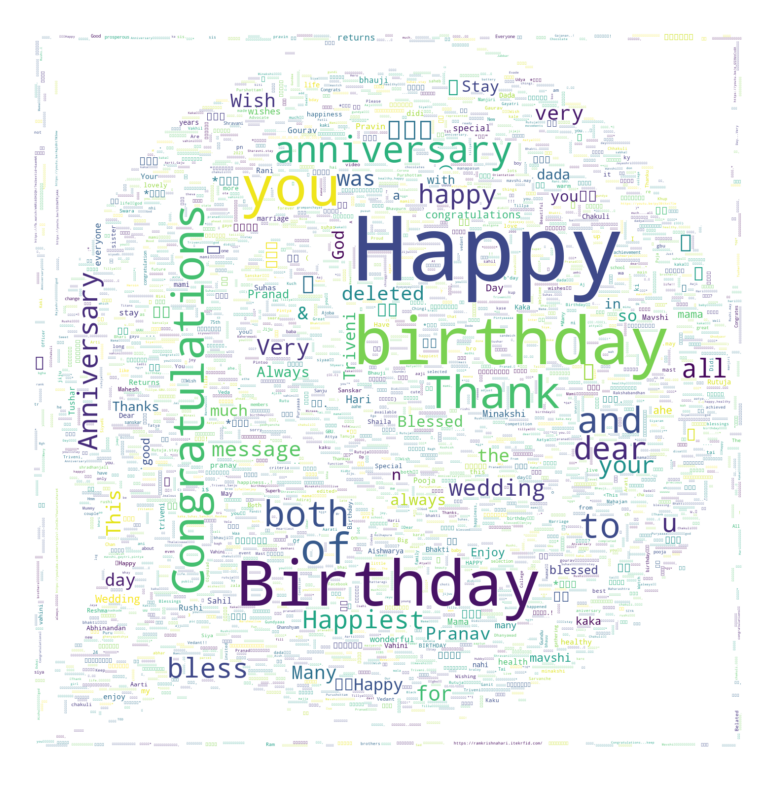

In [55]:
from PIL import Image
from wordcloud import WordCloud

# image = Image.open("logo.png")
# image.save("logo_4.png", quality = 40, optimize = True)

alice_mask = np.array(Image.open("logo.png"))

wc = WordCloud(background_color="white", max_words=5000, mask=alice_mask)
# generate word cloud
wc.generate_from_frequencies(word_frequency)

# show
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

---

### 📌 Most Common Words

In [56]:
most_common_words = pd.DataFrame(
    {
        'words':word_frequency.keys(),
        'count':word_frequency.values()
    }
).sort_values('count', ascending = False)
most_common_words

,words,count
6,Happy,945
14,birthday,435
7,Birthday,398
25,you,295
22,Thank,189
...,...,...
5109,विरोधाभास,1
5110,देशातला,1
5111,हिंदूंचा,1
5112,सर्वात,1


In [60]:
fig = go.Figure(
  go.Bar
    (
      y = most_common_words.head(10)['count'],
      x = most_common_words.head(10)['words'],
      name='most_common_words'
    )
)
fig.update_layout(
  height=500, 
  width=900,
  xaxis_title = "Words ➡️",
  yaxis_title = "Word Count ➡️",
  title="Most Common Words 📊",
  title_x=0.5,
  template="plotly_white",
  margin = dict(l=10, r=10)
)
fig.show()

---

### 📌 Most Common Emojis

In [58]:
most_common_emojis = {}
for i in range(most_common_words.shape[0]):
    for char_ in most_common_words.loc[i, 'words']:
        if emoji.is_emoji(char_):
            try:
                most_common_emojis[char_] += 1
            except KeyError:
                most_common_emojis[char_] = 1

most_common_emojis = pd.DataFrame(
    {
        'emojis':most_common_emojis.keys(),
        'count':most_common_emojis.values()
    }
).sort_values('count', ascending = False)

In [61]:
fig = go.Figure(
  go.Bar
    (
      y = most_common_emojis.head(10)['count'],
      x = most_common_emojis.head(10)['emojis'],
      name='most_common_words'
    )
)
fig.update_layout(
  height=500, 
  width=900,
  xaxis_title = "Emojis ➡️",
  yaxis_title = "Emojis Count ➡️",
  title="Most Common Emojis 🙂‍↔️",
  title_x=0.5,
  template="plotly_white",
  margin = dict(l=10, r=10)
)
fig.show()